# How to use the `delay_filter` module in `hera_cal`

`hera_cal`'s `delay_filter` module is an interface to the delay_filtering in `uvtools.dspec`. It allows for simple reading of data, performing the delay filter (based on baseline length), and then writing the results to disk.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from hera_cal.delay_filter import DelayFilter
from hera_cal.data import DATA_PATH
from hera_cal import io
import shutil

## Reading Data

Let's start by loading by creating a `DelayFilter` object and then loading in some data.

In [2]:
dfil = DelayFilter()
fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
dfil.load_data(fname, filetype='miriad')

Alternatively, we could load in data from a HERAData object.

In [3]:
dfil = DelayFilter()
hd = io.HERAData(fname, filetype='miriad')
hd.read()
dfil.load_data(hd)

`load_data` also supports lists of either of those kinds of input. `DelayFilter` objects also suport `load_data_as_dicts`, which allows one to directly input the data, flags, freqs and antpos. If either of these are used, writing to disk (see below) is not available.

Let's pick the 28 m EW baseline between antennas 37 and 39 and look a the data and flags.

In [4]:
bl = (37, 39, 'xx')

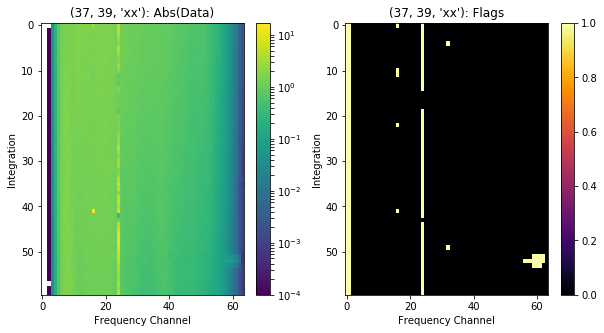

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(dfil.data[bl]), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(Data)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')

plt.subplot(122)
plt.imshow(np.array(dfil.flags[bl], dtype=float), aspect='auto', cmap='inferno')
plt.colorbar()
plt.title(str(bl) + ': Flags')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration');

## Performing the Delay Filter

Now let's run the filter. We can run the filter on all baselines simply with:

In [6]:
dfil.run_filter()

We can also filter just a specific baseline or baselines as a list:

In [7]:
dfil.run_filter(to_filter=[bl])

We can also use `run_filter` to access all the keyword arguments of `uvtools.dspec.delay_filter`. The weights default (i.e. `None`) to using the inverse of the flags of the data, but custom linear multiplicative weights can be provided.

In [8]:
dfil.run_filter(to_filter=[bl], weight_dict = None, standoff=15., horizon=1.,
                tol=1e-9, window='blackman-harris', skip_wgt=0.1, maxiter=100)

The results are stored in the `DelayFilter` object. `filtered_residuals` is a `DataContainer` that maps baseline/pol keys to the results of the high-pass filter. `CLEAN_models` is also a `DataContainer` that contains the smooth spectrum components found iteratively by `uvtools.dspec.delay_filter` (which itself uses `aipy.deconv.clean`).

Now let's plot some reuslts. Running delay filter removes a lot of the large-spectral scale power in the data. Clearly, there's some power left in, in part due to the band edges and in part due to unflagged RFI. 

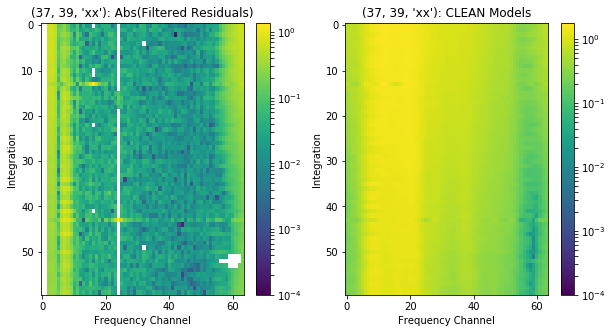

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
res = dfil.filtered_residuals[bl]
res[dfil.flags[bl]] = 0
plt.imshow(np.abs(res), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(Filtered Residuals)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')

plt.subplot(122)
plt.imshow(np.abs(dfil.CLEAN_models[bl]), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': CLEAN Models')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration');

The `DelayFilter` also stores the `info` returned from each frequency that the delay CLEANing was performed on. This includes some information about whether or not it ran successfully.

In [10]:
print dfil.info[bl][0]

{'term': 'tol', 'score': 0.001979366046126994, 'success': True, 'tol': 1e-09, 'iter': 1}


## Writing the Results to Disk

When data is loaded via a single string path or a single `UVData` object, `DelayFilter` objects enable easy writing to disk of the results. This uses `hera_cal.io.update_vis` to update the input visibility data file or object, only modifying the visibility data.

In [11]:
outfile = os.path.join(DATA_PATH, "test_output/sample_delay_filter_output.uv")
dfil.write_filtered_data(res_outfilename=outfile, filetype='miriad', clobber=True)

`write_filtered_data` supports a number of options that interface with `update_vis` to update other desired parameters. One can choose the filetype of the output, whether to allow the output to overwrite ("clobber") a file in the same location, whether to write out the CLEAN_models (i.e. the low-pass component), and what to append to the history. One can also pass updates to UVData parameters via `**kwargs`.

In [12]:
dfil.write_filtered_data(CLEAN_outfilename=outfile, filetype='miriad', clobber=True,
                         add_to_history = 'Written with running_delay_filter.ipynb.')

File exists: clobbering


In [13]:
shutil.rmtree(outfile)

## Partial I/O

Both reading via `load_data` (using `**read_kwargs`) and writing via `write_filtered_data` support partial data I/O (though the latter only via uvh5 and then only if the data itself was loaded with uvh5).

Doing so in a way that loops over and delay filters a whole file can be done using `hera_cal.delay_filter.partial_load_delay_filter_and_write`, loading, delay_filtering, and writing `Nbls` at a time. This can be done from the commandline using the delay_filter_run.py script by specifying an interger number for `partial_load_Nbls`.